# Rideshare Usage Prediction with Random Forest Regression

**Background**

Since November 2018, rideshare providers (Lyft, Uber, etc) operating in Chicago are required by ordinance to submit periodic data reports with basic rideshare information to the City.  The main [Trips dataset](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p) includes information about individual rides, including starting and ending times and locations, fares and tips, and whether the rides were pooled.  The Trips data are anonymized, so trip starting and ending locations are generalized to the nearest census tract, and drivers cannot be linked to particular rides they provided.  The currently available dataset goes through June 2019, however the portion used for this exercise goes from November 2018 through March 2019.

To prepare for the analyses and visualizations in this notebook, the Trips data was cleaned, aggregated, and enriched with climate and census data.  A preliminary exploration of this dataset is available [here](https://github.com/LisaATaylor/Rideshare/blob/master/Chicago%20Rideshare%20Data%20Story.ipynb).

The primary question explored by this notebook is how well can we predict the number of rideshare pickups for a given location as a function of day of week and time of day?  We are also interested in knowing whether the additional information that has been added to enrich the base dataset (ie climate, census, and distance data) may enhance the ability to predict usage.

1.  [Setup and data loading](#setup)
2.  [Prediction of rideshare demand by OLS](#ols)
3.  [Prediction of rideshare demand by non-parametric model](#np)
4.  [Enhancement of dataset - adding 'Bearing' field](#bear)
5.  [Parameter tuning](#param)
6.  [Final results](#final)


<a id='setup'></a>

---

## 1. Setup and Data Loading

In [67]:
import csv
import os
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as ctx #for basemaps
import scipy.stats as stats

In [68]:
plt.rcParams['figure.figsize'] = [15, 5]
sns.set()
import warnings; warnings.simplefilter('ignore')

In [111]:
#load pickled/munged data 
datadir=r'/Users/rtaylor/Desktop/Springboard/DataSets/Rideshare'

#data from 5% sample from Trips dataset, aggregated by pickup census tract and hour
agg_hourly_all=pd.read_pickle(os.path.join(datadir,'agg_hourly_all_gdf'))

agg_hourly_all['MedIncome']=agg_hourly_all.MedIncome.astype('int') #was object

In [70]:
agg_hourly_all.iloc[0]

Fare                                                                 5
Tip                                                                  0
AdditionalCharges                                                  2.5
TripTotal                                                          7.5
TripMiles                                                          1.9
TripSeconds                                                      683.5
Year                                                              2018
Month                                                               11
DOW                                                                  3
Hour                                                                16
NumRides                                                             2
HTemp                                                               48
HWind                                                               21
HPrecip                                                              0
Precip

#### About the data:
The hourly aggregated rideshare dataset was generated by grouping the raw rides data by census tract and time rounded to the nearest hour.  The fields derived from the Trips dataset (Fare, Tip, Trip Miles, etc.) are average values for all rides in each time/space grouping.  The count of rides per grouping is used to derive the NumRides field.  This data has been enriched with weather data (HTemp = hourly temperature, HPrecip = hourly precipitation accumulation, HWind= hourly average wind speed, Precip = flag whether precipitation occurred), plus limited census-derived and geographic data for each census tract (Med Income, Population Density, Distance to Downtown).

Each record in the aggregated dataset represents a summary of rideshare activity at a location for a given date and time (to nearest hour).  Since the dataset used for aggregation only includes 5% of the total rides, the computed ride counts can be considered estimates of 5% of total utilization.  For this analysis, each record has been decoupled from the actual month/date/year and acts an individual sample representative of a day of week and hour of day. For instance, for a given tract there will be multiple samples of ride count or average fare for a given Wednesday at 4pm.  There are no records for tracts at times when they had no rides (i.e. NumRides is always >=1).

In [71]:
#Some of the variables in this dataset are strongly corellated
agg_hourly_all[['TripTotal','Fare','TripMiles','TripSeconds','DistToDowntown','PopDensity','MedIncome']].corr()

,TripTotal,Fare,TripMiles,TripSeconds,DistToDowntown,PopDensity,MedIncome
TripTotal,1.000000,0.971472,0.820143,0.667418,0.189242,-0.058795,-0.335548
Fare,0.971472,1.000000,0.833237,0.710880,0.206805,-0.061765,-0.290182
TripMiles,0.820143,0.833237,1.000000,0.786245,0.283238,-0.104236,-0.303378
TripSeconds,0.667418,0.710880,0.786245,1.000000,0.234138,-0.081948,-0.183287
DistToDowntown,0.189242,0.206805,0.283238,0.234138,1.000000,-0.200470,-0.270998
PopDensity,-0.058795,-0.061765,-0.104236,-0.081948,-0.200470,1.000000,0.147297
MedIncome,-0.335548,-0.290182,-0.303378,-0.183287,-0.270998,0.147297,1.000000


<a id='demand_predict'></a>

<a id='ols'></a>

## 2. Applicability of linear regression approach

First I considered applying a basic linear regression approach to see if a simple linear model may be effective at predicting ride counts at specified locations and times. The exploratory data analysis showed strong cyclical effects in rideshare usage at the hourly and daily levels, and a strong relationship between demand and distance to downtown at certain times of day. Given the repeatability of the usage data, the goal is to predict usage by distance from downtown, a general date and time (i.e. weekend or weekday, time of day), and other variables which may influence demand (weather, etc). 

Some new engineered features were added to the dataset to see if they aid in prediction:
* **IsAirportPU:**  The preliminary data analysis indicated that the airports have different patterns than other parts of the city.  This flag identifies rides that originate at an airport.  Since we are interested in pickup demand, not dropoff demand, we only derive this for pickups.
* **DayPeriod:**  If hour of day is used as a model parameter, there is no way to inform the model that hour is cyclical (i.e. 0:00 is close to both 23:00 and 1:00), other than performing a sin/cos-type transform.  As a simpler approach, I derived time of day groupings (i.e. morning, afternoon, etc) that can be used as a categorical indicator of the time of day.
* **IsWeekday:**  The time series usage data showed very different behavior between weekday and weekend rides.  This field was added to see if a categorical flag for weekend/weekday may produce better results than day of week.

Several of the features in the original Trips dataset are strongly correlated (i.e. fare, trip duration, trip distance).  Due to these strong relationships I only incorporated a single one of these features in each attempted regression model to avoid multicollinearity. 

A major issue here is that the response variable, NumRides, is not normally distributed.  Since NumRides (pickup rate per hour) is derived from aggregating data for rides that occurred, it is always greater than zero.  As such, it appears to resemble a zero-truncated Poisson random variable, which has a minimum of 1.  There doesn't appear to be a GLM model that can handle this in statsmodels, so I abandoned this approach.  At the end of this notebook (see [here](#glm)) is an attempt to fit a Negative Binomial GLM to a different version of the dataset that includes records for locations/times having zero rides per hour. 

In [112]:
#Derived fields

agg_hourly_all=agg_hourly_all.reset_index() 

#Add in airport flag
agg_hourly_all['IsAirportPU']=0
agg_hourly_all.loc[agg_hourly_all.PUCensusTract.isin(['17031980000','17031980100']),'IsAirportPU']=1

#add flag to indicate period of day
agg_hourly_all['DayPeriod'] = pd.cut(agg_hourly_all['Hour'], bins=[-1,6, 10, 14, 17, 20, 24], labels=['night', 'morning', 'midday','afternoon','evening','lateevening'])

#Add flag for weekday/weekend
agg_hourly_all['IsWeekday'] = 0
agg_hourly_all.loc[agg_hourly_all.DOW<5,'IsWeekday']=1

In [73]:
agg_hourly_all[['PUCensusTract', 'TripStart', 'Fare', 'Tip', 'AdditionalCharges',
       'TripTotal', 'TripMiles', 'TripSeconds', 'Year', 'Month', 'DOW', 'Hour',
       'NumRides', 'HTemp', 'HWind', 'HPrecip', 'Precip','commarea','area_sq_km', 'MedIncome', 'Population',
       'PopDensity', 'DistToDowntown', 'IsAirportPU', 'DayPeriod',
       'IsWeekday']].iloc[0]

PUCensusTract                17031010100
TripStart            2018-11-01 16:00:00
Fare                                   5
Tip                                    0
AdditionalCharges                    2.5
TripTotal                            7.5
TripMiles                            1.9
TripSeconds                        683.5
Year                                2018
Month                                 11
DOW                                    3
Hour                                  16
NumRides                               2
HTemp                                 48
HWind                                 21
HPrecip                                0
Precip                               Dry
commarea                               1
area_sq_km                      0.380787
MedIncome                          33750
Population                          4444
PopDensity                       11670.6
DistToDowntown                   15.5667
IsAirportPU                            0
DayPeriod       

In [488]:
# Try OLS regression with statsmodels

# At this point we just want to see whether an OLS modelling approach is appropriate and can give us 
# insight into the data.
# Since we are not yet concerned with overfitting the data, the input data has not been scaled and 
# regularization has not been applied. I also use the entire dataset to split the model.
# Works best with log transform of NumRides to prevent negative values

import statsmodels.formula.api as smf

#I tried a variety of linear models, including with interactions bewteen parameters.  Did not achieve a model with R-squared above 0.15
#results=smf.ols('NumRides ~ DistToDowntown+TripMiles+C(DOW)+C(IsWeekday)+C(IsAirportPU)',data=agg_hourly_all).fit()
#results=smf.ols('NumRides ~ DistToDowntown+TripTotal+HTemp+C(Precip)+C(IsAirportPU)+Hour+C(DOW)',data=agg_hourly_all).fit()
results=smf.ols('np.log(NumRides) ~ DistToDowntown+TripTotal+C(Precip)+C(IsAirportPU)+C(DayPeriod)+C(IsWeekday)',data=agg_hourly_all).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(NumRides)   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                 1.839e+04
Date:                Wed, 13 Nov 2019   Prob (F-statistic):               0.00
Time:                        13:43:50   Log-Likelihood:            -5.5972e+05
No. Observations:              537380   AIC:                         1.119e+06
Df Residuals:                  537369   BIC:                         1.120e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       1.0647      0.004    296.386      0.000       1.058       1.072
C(Precip)[T.1]                  0.0371      0.005      7.338      0.000       0.027       0.047
C(IsAirportPU)[T.1]             2.1191      0.010    213.249      0.000       2.100       2.139
C(DayPeriod)[T.morning]         0.1148      0.003     34.083      0.000       0.108       0.121
C(DayPeriod)[T.midday]          0.1026      0.003     30.023      0.000       0.096       0.109
C(DayPeriod)[T.afternoon]       0.1567      0.004     44.151      0.000       0.150       0.164
C(DayPeriod)[T.evening]         0.3437      0.003    100.382      0.000       0.337       0.350
C(DayPeriod)[T.lateevening]     0.2361      0.004     64.511      0.000       0.229       0.243
C(IsWeekday)[T.1]              -0.1075      0.002    -52.706      0.000      -0.112      -0.104
DistToDowntown                 -0.0892      0.000   -395.260      0.000      -0.090      -0.089
TripTotal                       0.0016      0.000     10.847      0.000       0.001       0.002
==============================================================================
Omnibus:                    51240.461   Durbin-Watson:                   0.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            68560.570
Skew:                           0.802   Prob(JB):                         0.00
Kurtosis:                       3.698   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Overall OLS regression results:

In general, the OLS approach shows significant relationships between the predictors and pickup demand, however the overall predictive power of the regression model is low, and the quality of model predictions are poor. 


<a id='np'></a>

## 3.  A different approach:  non-parametric models

Given the poor performance of the linear model, I switched directions and attempted to implement a non-parametric modeling approach to predict rideshare usage. Unlike regression, non-parametric models make no assumption about the functional form of the relationship between the parameters and the dependent variable, and have the potential to perform better in this application.   

Non-parametric models that may be applied to this problem include k-Nearest Neighbors regression, RBF-kernel SVM regression, and tree-based regression approaches (i.e. decision trees, bagging, boosting, random forest).  Given the large dataset available to train the model, the tree-based approach was selected.  An advantage of tree-based models is that they require very little data preparation.  I start with an out-of-box Random Forest regressor, and train it on a subset of the parameters.  The results, scored on the test data, are compared with the results from out-of-box gradient boosting and bagging regressors.

Because we are using time series data, we cannot use a random train test split. Instead we use the first 2/3 for training and the latter 2/3 for test.

The EDA also suggested that Holidays have an effect on Rideshare usage.  An IsHoliday flag was added to the data to enable either filtering out these dates or incorporating them into the model.


In [272]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#retreive updated dataset with added angle from downtown (bearing) field
#data is sorted by time, so split should produce before and after datasets
hgdf=pd.read_pickle(os.path.join(datadir,'new_hourly_data_census_geo'))
hgdf=hgdf.loc[(hgdf.NumRides>0)&~hgdf.IsHoliday&~hgdf.IsAirport]#filter out holidays and records with zero rides (added for prior experiment not documented here)
hgdf['Precip']=hgdf['Precip'].map({'Dry':0,'Wet':1})


In [273]:
# a few functions
def train_test_split_ts(XX,yy,test_size=0.33):
    #splits time-series data to generate train and test datasets.  XX and yy must be sorted by time.
    #train = before, test=after
    train_size=int((1-test_size)*XX.shape[0])

    train=list(range(0,train_size))
    test=list(range(train_size,len(XX)))

    XX_train=XX.iloc[train]
    XX_test=XX.iloc[test]
    yy_train=yy.iloc[train]
    yy_test=yy.iloc[test]
    return(XX_train,XX_test,yy_train,yy_test)

def fit_score_model(mod,Xtrain,Xtest,ytrain,ytest):
    #fits model to train
    #returns fitted model, ytrain predicitons,ytest predictios
    M=mod
    M.fit(Xtrain,ytrain)
    ypred=M.predict(Xtest)
    ypredtrain=M.predict(Xtrain)
    rsq=M.score(Xtest,ytest)
    rmse=np.sqrt(mean_squared_error(ytest,ypred))
    mname=type(M).__name__
    print('Result for {}\nR2:  {}   RMSE:  {} '.format(mname,rsq,rmse))
    return(M,ypredtrain,ypred)
    
##test area
#mm,y1,y2=fit_score_model(RandomForestRegressor(),X_train, X_test, y_train, y_test)

In [274]:
#try out of box random forest regressor with a subset of parameters

Xb=hgdf[['DistToDowntown','Hour','DOW','MeanMiles','Precip']]#'TripTotal',
yb=hgdf['NumRides']
X_train, X_test, y_train, y_test = train_test_split_ts(Xb, yb, test_size=0.33)

#rfrmod=RandomForestRegressor()
#rfrmod.fit(X_train,y_train)
#y_pred=brmod.predict(X_test)
rfrmod_ts,y_pred_train,y_pred_test=fit_score_model(RandomForestRegressor(),X_train, X_test, y_train, y_test)

Result for RandomForestRegressor
R2:  0.8173171834371045   RMSE:  1.887632809347574 


#### Result:  
This simple, out-of-box model achieved an R-squared of 0.81 on the test data.  The results demonstrate that rideshare pickup rates for locations within Chicago can be fairly accurately predicted using a random forest model given a few pieces of information (distance to downtown, time of day, day of week, whether its raining, average trip distance at that location/time, and whether the pickup is from the airport).  

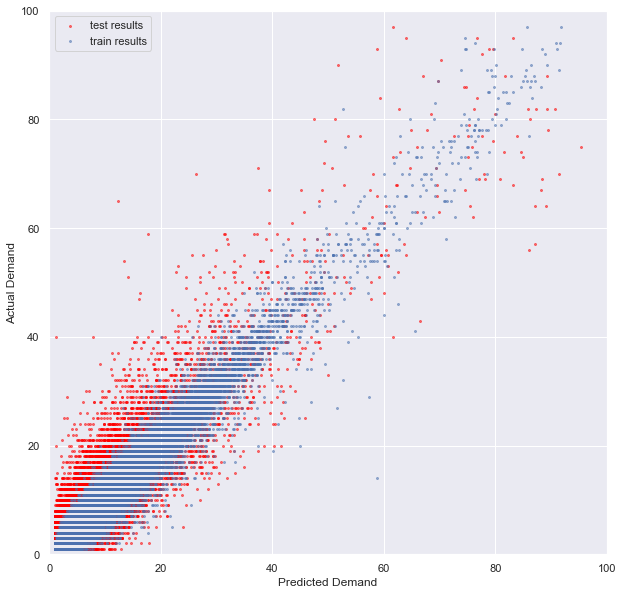

In [275]:
#Look at data graphically, plot predicted usage vs actual for first 50,000 records
def scatter_fit(y_train,y_test,y_train_pred,y_test_pred,nrecords=500000):
    #function for generating scatter plots illustrating goodness of fit (fitted vs actual ride counts)
    #need to add logic for checking nrecords against data (number of records to plot)
    fig,ax=plt.subplots(figsize=[10,10])
    ax.scatter(y_test_pred[:nrecords],y_test[:nrecords],color='red',label='test results',s=4,alpha=0.5)
    #y_train_pred=rfrmod_ts.predict(X_train)
    ax.scatter(y_train_pred[:nrecords],y_train[:nrecords],label='train results',s=4,alpha=0.5)
    ax.set_xlabel('Predicted Demand')
    ax.set_ylabel('Actual Demand')
    ax.set_ylim(0,100)
    ax.set_xlim(0,100)
    ax.legend();
scatter_fit(y_train,y_test,y_pred_train,y_pred_test)

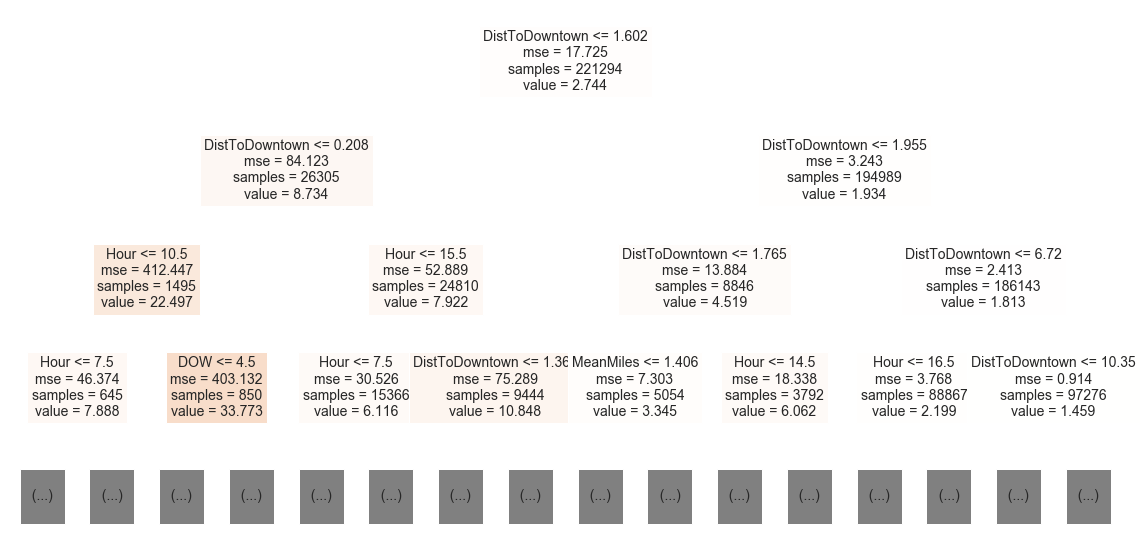

In [276]:
from sklearn.tree import plot_tree
mod=rfrmod_ts.estimators_[8]
fig,ax=plt.subplots(figsize=(20,10))
plot_tree(mod, max_depth=3,feature_names=X_train.columns, filled=True,fontsize=14);

#to do:  figure out how to format this plot better

**Result:** 

After inspecting the top few levels of multiple models, we see splits on distance, hour and airport occuring at the top levels.

In [277]:
#Try Gradient Boosting with same data
gbrmod,y_pred_train,y_pred_test=fit_score_model(GradientBoostingRegressor(),X_train, X_test, y_train, y_test)


Result for GradientBoostingRegressor
R2:  0.6750896642999356   RMSE:  2.5173895863134956 


#### Result: 
The Out-of-box boosting regressor does not perform as well as random forest.

In [278]:
#Try Bagging
bagmod,y_pred_train,y_pred_test=fit_score_model(BaggingRegressor(),X_train, X_test, y_train, y_test)


Result for BaggingRegressor
R2:  0.8158814536080656   RMSE:  1.8950358776256833 


#### Result: 
The bagging regressor produces similar results to random forest.  This may be expected, since there are a small number of parameters and since trees are not being pruned.

In [279]:
#Try using fare as predictor instead of distance
Xb=hgdf[['DistToDowntown','Hour','DOW','MeanFare','Precip']]#'TripTotal',

X_train, X_test, y_train, y_test = train_test_split_ts(Xb, yb, test_size=0.33)

rfrmod_f,y_pred_train,y_pred_test=fit_score_model(RandomForestRegressor(),X_train, X_test, y_train, y_test)

Result for RandomForestRegressor
R2:  0.8400184393654408   RMSE:  1.766459287219233 


{'DistToDowntown': 0.5114179409138888, 'Hour': 0.21900250193357404, 'DOW': 0.0718407237966309, 'MeanFare': 0.19442963516487202, 'Precip': 0.003309198191034239}


<BarContainer object of 5 artists>

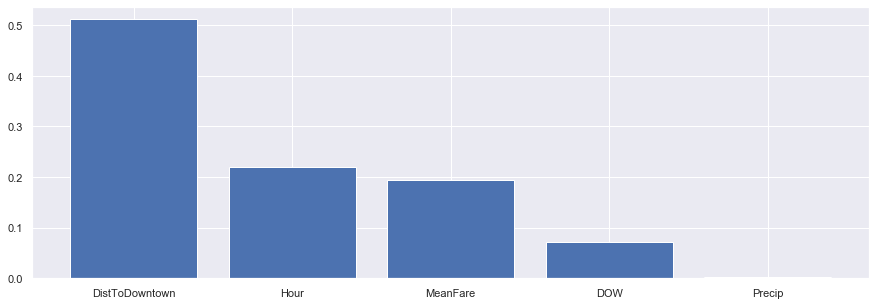

In [280]:
print(dict(zip(Xb.columns,rfrmod_f.feature_importances_)))
a,b=zip(*sorted(zip(Xb.columns,rfrmod_f.feature_importances_), key=lambda pair: pair[1],reverse=True)) 
plt.bar(a,b)

#### Result: 
By swapping fare for distance the R-squared for test data has reduced to 0.84. The same switch was attempted with ride time with R2 of 0.80.  So fare appears to be the best trip characteristic (vs distance and time) for predicting usage.  The feature importance plot shows distance to downtown is most important, followed by hour, fare, and day of week.  

<a id='bear'></a>

## 4. Parameter Selection
The EDA provided evidence that rideshare usage is focused on downtown, with a sharp dropoff in utilization as the pickup spot moves outwards from the city center.  The baseline model was built using distance from downtown as a spatial metric.  For this enhancement, a "Bearing" field was added to the data to indicate the direction of the pickup spot relative to downtown, in degrees relative to North (i.e. a pickup location due west of downtown has a bearing of 270).  In essence,the xy coordinates of the pickup locations have been converted to radial coordinates expressed as distance and angle relative to downtown Chicago.  The code used to perform this coordinate transformation is provided in my python module [RideshareDataPrep].(https://github.com/LisaATaylor/Rideshare/blob/master/RideshareDataPrep.py)

Precipitation did not appear to be important to the model and was removed from the parameter set.


In [315]:
#Try out of box random forest, add bearing, remove precip
Xb=hgdf[['DistToDowntown','bearing','Hour','DOW','MeanFare']]#'TripTotal',

Xb_train, Xb_test, yb_train, yb_test = train_test_split_ts(Xb, yb, test_size=0.33)
rfrmod_e,y_pred_train,y_pred_test=fit_score_model(RandomForestRegressor(),Xb_train, Xb_test, yb_train, yb_test)
#very minor improvement

Result for RandomForestRegressor
R2:  0.8419247912824229   RMSE:  1.7559031172551323 


In [316]:
#Revisit bagging
bagmod_e,y_pred_train,y_pred_test=fit_score_model(BaggingRegressor(),Xb_train, Xb_test, yb_train, yb_test)

Result for BaggingRegressor
R2:  0.8417013250858598   RMSE:  1.7571438127966093 


**Result:**  

Adding in the bearing produced a very minor improvement in R-squared and RMSE.  Distance from downtown, hour, and mean fare (per date, time, location) remain the most important predictors of utilization.

In [322]:
#are there other parameters not correlated with the main predictors that can be included?
hgdf[['DistToDowntown','bearing','Hour','DOW','MeanFare','Precip','MedIncome','PopDensity']].corr()
#Med income correlated with distance

,DistToDowntown,bearing,Hour,DOW,MeanFare,Precip,MedIncome,PopDensity
DistToDowntown,1.000000,0.115597,0.042470,0.013030,0.135455,-0.004183,-0.470162,-0.169920
bearing,0.115597,1.000000,0.000442,-0.013533,0.028637,-0.000926,-0.011793,0.019572
Hour,0.042470,0.000442,1.000000,-0.017889,-0.116074,0.012672,-0.015899,-0.025103
DOW,0.013030,-0.013533,-0.017889,1.000000,-0.030917,0.033868,0.019511,0.020792
MeanFare,0.135455,0.028637,-0.116074,-0.030917,1.000000,0.000317,-0.056468,-0.020697
Precip,-0.004183,-0.000926,0.012672,0.033868,0.000317,1.000000,0.007665,0.004815
MedIncome,-0.470162,-0.011793,-0.015899,0.019511,-0.056468,0.007665,1.000000,0.082712
PopDensity,-0.169920,0.019572,-0.025103,0.020792,-0.020697,0.004815,0.082712,1.000000


In [325]:
#try random forest with all the parameters including population density
Xb5=hgdf[['DistToDowntown','bearing','Hour','DOW','MeanFare','Precip','PopDensity']]#'TripTotal',

Xb5_train, Xb5_test, yb5_train, yb5_test = train_test_split_ts(Xb5, yb, test_size=0.33)
rfrmod_e5,y_pred_train,y_pred_test=fit_score_model(RandomForestRegressor(),Xb5_train, Xb5_test, yb5_train, yb5_test)

Result for RandomForestRegressor
R2:  0.8426459472532928   RMSE:  1.7518932299442616 


{'DistToDowntown': 0.36241203097038627, 'bearing': 0.09858284588080643, 'Hour': 0.2242774204029156, 'DOW': 0.07560827410368723, 'MeanFare': 0.1855917041680509, 'Precip': 0.0032934312078095767, 'PopDensity': 0.05023429326634401}


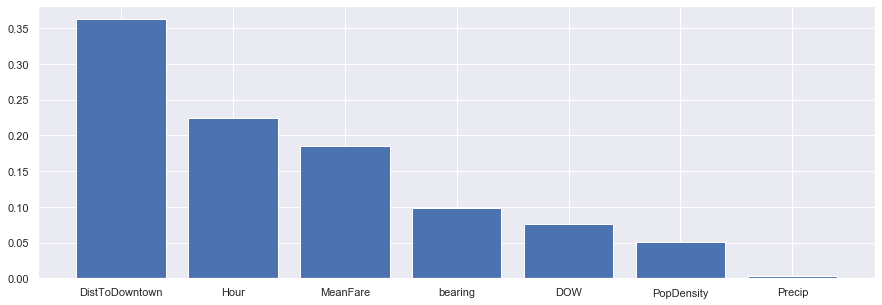

In [323]:
#Feature Importances
print(dict(zip(Xb5.columns,rfrmod_e5.feature_importances_)))
a,b=zip(*sorted(zip(Xb5.columns,rfrmod_e5.feature_importances_), key=lambda pair: pair[1],reverse=True)) 
plt.bar(a,b);

In [330]:
#Final parameter selection
Xb6=hgdf[['DistToDowntown','bearing','Hour','DOW','MeanFare','PopDensity']]#'TripTotal',

Xb6_train, Xb6_test, yb6_train, yb6_test = train_test_split_ts(Xb6, yb, test_size=0.33)
rfrmod_e6,y_pred_train,y_pred_test=fit_score_model(RandomForestRegressor(),Xb6_train, Xb6_test, yb6_train, yb6_test)

Result for RandomForestRegressor
R2:  0.8432641221373699   RMSE:  1.7484486344465604 


**Result**

Adding other parameters does not lead to significant improvements in model fit.  The best model, achieved in the prior cell, is only slightly better than the original model.

<a id='param'></a>

## 5.  Hyperparameter Tuning

The Random Forest Regressor is trained by fitting a series of decision trees to bootstrap samples taken from the training dataset.  Because we are predcting ride demand using time series data, we cannot use the out-of-bag (OOB) sample (portion of the dataset not included in the bootstrap sample) to score the model, because the missing samples will be highly correlated with other samples adjacent in the time series that are included in the bootstrap.  

Instead, the time series data are partitioned into four contiguous portions using the TimeSeriesSplit function in scikit learn.  Over three iterations, the model is trained on the early portion (subsets 1, 1+2, and 1+2+3), and then scored on the equally-sized later subsets (2, 3, and 4).  The resulting R-squared scores for each iteration are averaged to produce the final score. 


In [333]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3)

n_est=[10,20,30,50]#10 is default
n_scores=[]
for n in n_est:
    print('Number of estimators: {}'.format(n))
    i_r2 =[]
    rfrmod_optn=RandomForestRegressor(n_estimators=n,n_jobs=-1) 
    for train_i,test_i in tss.split(Xb6):  #loop over each set of splits, split X and Y
        X_train, X_test = Xb6.iloc[train_i], Xb6.iloc[test_i]
        y_train, y_test = yb.iloc[train_i], yb.iloc[test_i]
        rfrmod_optn.fit(X_train,y_train)
        i_r2.append(rfrmod_optn.score(X_test,y_test))
    print(i_r2)
    #average r-squareds from each iteration
    avg_r2=np.mean(i_r2)
    n_scores.append(avg_r2)
    
#The final output is a dict with the average of r-squared values is returned for each parameter value being tuned.
results=dict(zip(n_est,n_scores))
print(results)

Number of estimators: 10
[0.7849712877521254, 0.8494220486537054, 0.840141066678564]
Number of estimators: 20
[0.792359816387245, 0.8539613218036175, 0.8437892028978051]
Number of estimators: 30
[0.7968931313758386, 0.855471317567069, 0.8450383048232236]
Number of estimators: 50
[0.7995968822216141, 0.8569530792463023, 0.8469326174573979]
{10: 0.8248448010281316, 20: 0.8300367803628892, 30: 0.8324675845887105, 50: 0.8344941929751047}


#### Results:
We see the best fit at n_estimators=50, though actual increase in r-squared is small.
Interestingly, the best model fits are achieved when fitting the first two folds to the third fold, not the first three to the fourth.

In [334]:
#use time series cross validation to optimize other parameters: selection of max_features, split criterion

#Max depth was run over several iterations to optimize the range of values (to identify best value):
#  first round 5,10,20,30 --> best = 20
#  second round 15,20,25 --> best = 15
#  third round 12,14,16,18 --> best = 16 (winner)

max_features=['sqrt','log2',None]#None equivalent to bagging
#max_depth=[5,10,20,30]#best score at 20 
#max_depth=[15,20,25]#best score at 15, feature selection=None
max_depth=[12,14,16,18]
for f in max_features:
    for d in max_depth:
        i_r2=[]
        rfrmod_optfd=RandomForestRegressor(n_estimators=10,max_features=f,max_depth=d,n_jobs=-1)
        for train_i,test_i in tss.split(Xb6):  #loop over each set of splits, split X and Y
            X_train, X_test = Xb6.iloc[train_i], Xb6.iloc[test_i]
            y_train, y_test = yb.iloc[train_i], yb.iloc[test_i]
            rfrmod_optfd.fit(X_train,y_train)
            i_r2.append(rfrmod_optfd.score(X_test,y_test))
        #average r-squareds from each iteration
        avg_r2=np.mean(i_r2)
        print('Feature Selection: {}    Max Depth: {}   OOB Score: {}'.format(f,d,avg_r2))

 

Feature Selection: sqrt    Max Depth: 12   OOB Score: 0.7995405177703724
Feature Selection: sqrt    Max Depth: 14   OOB Score: 0.8256754228482176
Feature Selection: sqrt    Max Depth: 16   OOB Score: 0.8326771548723837
Feature Selection: sqrt    Max Depth: 18   OOB Score: 0.831652035349681
Feature Selection: log2    Max Depth: 12   OOB Score: 0.8068466482856085
Feature Selection: log2    Max Depth: 14   OOB Score: 0.8205668705912439
Feature Selection: log2    Max Depth: 16   OOB Score: 0.8293905264823342
Feature Selection: log2    Max Depth: 18   OOB Score: 0.8315530942875146
Feature Selection: None    Max Depth: 12   OOB Score: 0.8254747812359531
Feature Selection: None    Max Depth: 14   OOB Score: 0.8383815425362208
Feature Selection: None    Max Depth: 16   OOB Score: 0.8406474120275145
Feature Selection: None    Max Depth: 18   OOB Score: 0.8375912515777962


#### Results:
We see the best results around tree max depth=16 and allowing all parameters to be used for a branch (i.e. bagging).  
Tree depth appears to be more important than the feature selection method.    

In [335]:
#let's try best combination of max_depth, max_features and n_estimators with original data split
rfrmod_final,y_pred_train,y_pred_test=fit_score_model(RandomForestRegressor(n_estimators=50,max_depth=16,max_features=None),Xb6_train, Xb6_test, yb_train, yb_test)


Result for RandomForestRegressor
R2:  0.8611228323790737   RMSE:  1.6458266606502774 


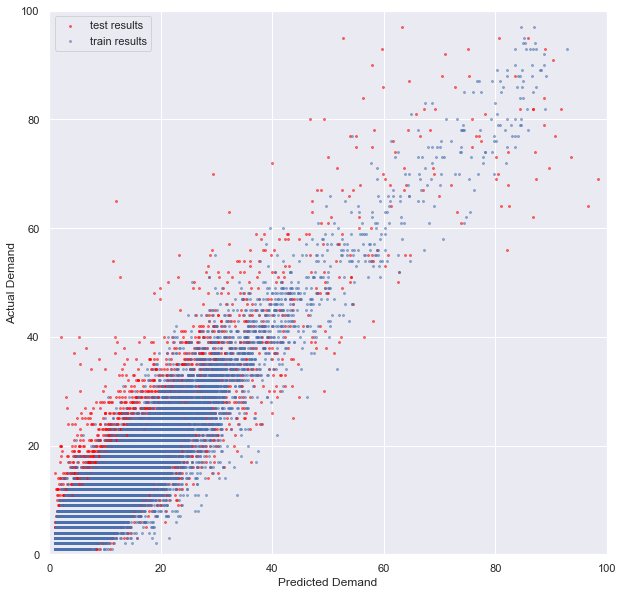

In [336]:
scatter_fit(yb_train,yb_test,y_pred_train,y_pred_test)


**Results**

After hyperparameter optimization of the Random Forest Regressor, the R-squared has increased from 0.84 to 0.86.

<a id='final'></a>

## 6.  Final Results
An Ipywidgets dashboard was created to illustrate the model output.  By selecting a few parameters, a snapshot of predicted rideshare usage can be generated for a typical week.

In [338]:
import ipywidgets as widgets
dist_range_slider = widgets.FloatLogSlider(value=1,min=-2,max=2,    step=0.2,    description='Distance: ',
    orientation='horizontal',layout={'width': '500px'})
bear_selector=widgets.Dropdown(options=[('N',0),('NE',45),('E',90),('SE',135),('S',180),('SW',225),('W',270),('NW',315)],
                               value=270,layout={'width':'200px'},description='Direction:')
#income_slider = widgets.IntSlider(value=50000,min=20000,max=300000,    step=20000,    description='Income: ',
#    orientation='horizontal',layout={'width': '500px'})
density_slider = widgets.IntSlider(value=8000,min=2000,max=12000,    step=1000,    description='Density: ',
    orientation='horizontal',layout={'width': '500px'})
fare_slider = widgets.IntSlider(value=10,min=1,max=100,    step=1,    description='Mean Fare: ',
    orientation='horizontal',layout={'width': '500px'})
#precip_checkbox=widgets.Checkbox(value=False,description='Precipitation')
#airport_checkbox=widgets.Checkbox(value=False,description='Airport')

def predict_usage(distance=1,bearing=180,density=8000,fare=10):#(tract):##,precip=0,isairport=0,income=50000,isairport=0):#month,temperature,isholiday,side,model):
    model=rfrmod_final
    data=dict()
    
    data['distance']=distance
    #data['precip']=precip
    #data['isairport']=isairport
    data['bearing']=bearing
    data['density']=density
    #data['income']=income
    data['fare']=fare

    to_predict=pd.Series(data).to_frame(1).transpose()#one record
    to_predict_df=pd.concat([to_predict]*168)#copy for each day of week and hour of day combination
    to_predict_df['Hour']=list(range(24))*7
    to_predict_df['DOW']=list(range(7))*24

    #to_predict_df=to_predict_df[['DistToDowntown','bearing','Hour','DOW','IsAirport','MedIncome','PopDensity','MeanFare','Precip']]#reorder columns
    to_predict_df=to_predict_df[['distance','bearing','Hour','DOW','fare','density']]#,'fare','precip']]#reorder columns

    to_predict_df['result']=model.predict(to_predict_df)

    heatdf=pd.pivot_table(data=to_predict_df,index='DOW',columns='Hour',values='result',aggfunc='sum')
    heatdf.index=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    heatdf=heatdf.fillna(0)
    fig,axes=plt.subplots(1,1,figsize=(15,4))
    sns.heatmap(heatdf,ax=axes,vmin=0,vmax=20)

widgets.interact(
    predict_usage,
    #tract=tractselector
    distance=dist_range_slider,
    bearing=bear_selector,
    density=density_slider,
    income=income_slider,
    fare=fare_slider,
    precip=precip_checkbox,
    #isairport=airport_checkbox
);

interactive(children=(FloatLogSlider(value=1.0, description='Distance: ', layout=Layout(width='500px'), max=2.…

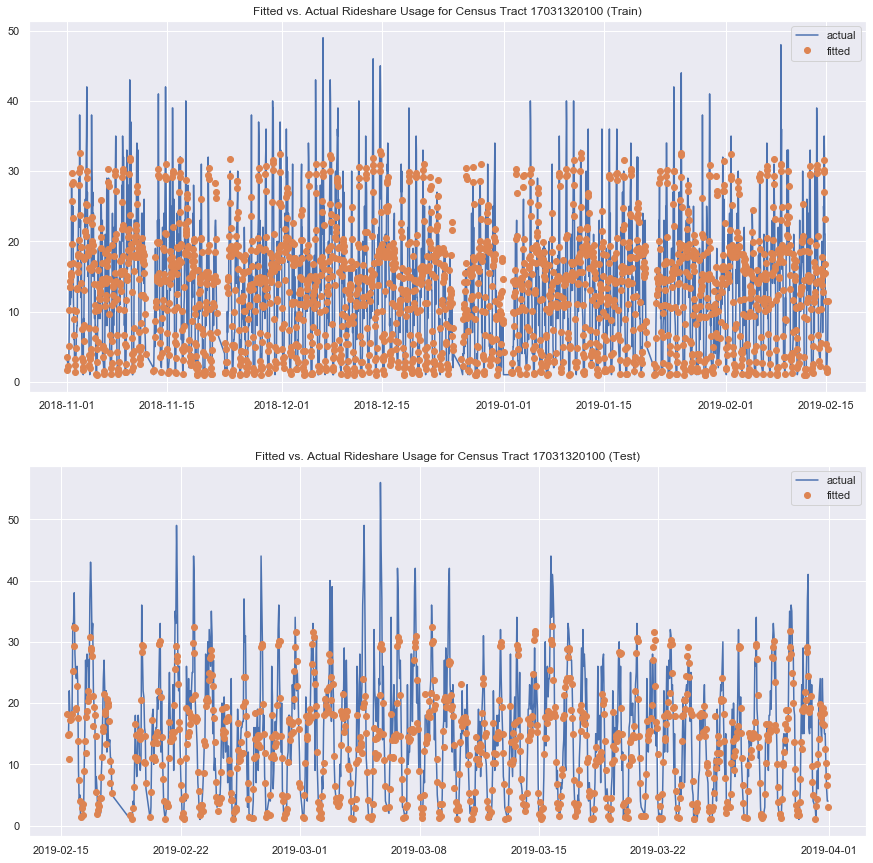

In [339]:
#Plot results for single census tract
def plot_timeseries(ax,y,ypred,tract,phase='Train'):
    #plot timeseries of actual and predicted
    tract=tract
    yc=y.to_frame()
    yc['y_pred']=ypred
    plotdf=yc.loc[y.index.get_level_values('PUCensusTract')==tract]
    ax.plot(plotdf.index.get_level_values('DATE'),plotdf['NumRides'],label='actual')
    ax.plot(plotdf.index.get_level_values('DATE'),plotdf['y_pred'],'o',label='fitted')
    ax.legend()
    ax.set_title('Fitted vs. Actual Rideshare Usage for Census Tract '+tract+ ' ('+phase+')')


fig,axs=plt.subplots(2,1,figsize=(15,15))
tract='17031320100'
plot_timeseries(axs[0],yb_train,y_pred_train,tract=tract,phase='Train')
plot_timeseries(axs[1],yb_test,y_pred_test,tract=tract,phase='Test')

### Final visualizations for report, presentation

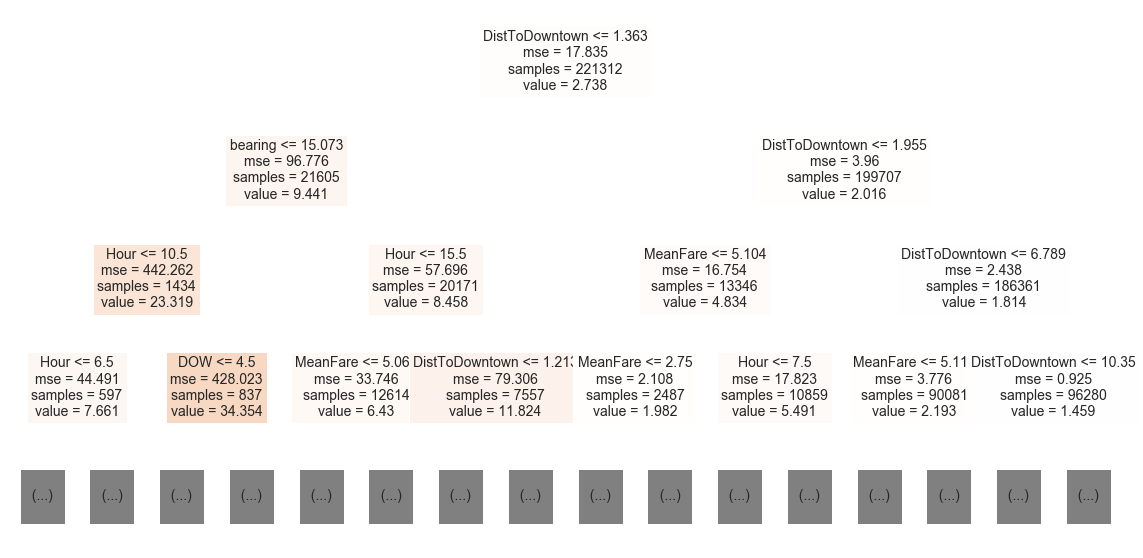

In [341]:
#inspect example from final ensemble of trees
mod=rfrmod_final.estimators_[0]
fig,ax=plt.subplots(figsize=(20,10))
plot_tree(mod, max_depth=3,feature_names=Xb6_train.columns, filled=True,fontsize=14);


{'DistToDowntown': 0.39188476261260696, 'bearing': 0.06993506909778174, 'Hour': 0.22623239481601906, 'DOW': 0.06994603758170892, 'MedIncome': 0.028584032382553703, 'PopDensity': 0.05568880378096284, 'MeanFare': 0.15549168411915842, 'Precip': 0.0022372156092083486}


<BarContainer object of 8 artists>

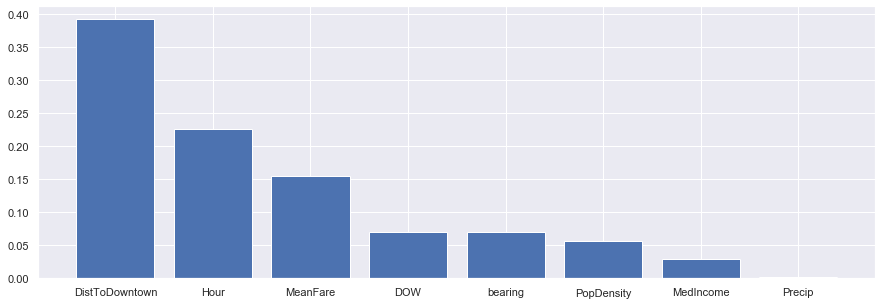

In [294]:
#Feature Importances
print(dict(zip(Xb.columns,rfrmod_final.feature_importances_)))
a,b=zip(*sorted(zip(Xb.columns,rfrmod_final.feature_importances_), key=lambda pair: pair[1],reverse=True)) 
plt.bar(a,b)

In [ ]:
#Below is visualization of time series of system-wide demand (used for report)

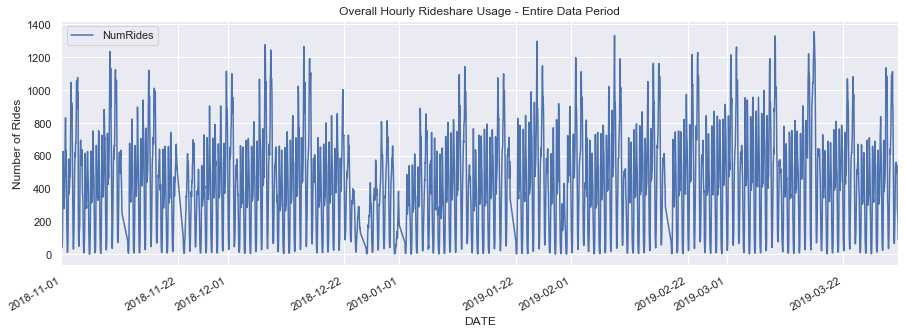

In [271]:
ndf=hgdf.reset_index()
tdf=ndf[['DATE','NumRides']].groupby(ndf['DATE']).sum()
tdf.plot()
plt.title('Overall Hourly Rideshare Usage - Entire Data Period')
plt.ylabel('Number of Rides');


<a id='glm'></a> 

#### GLM attempt
Below is the result of attempting a GLM to predict average daily pickups per census tract as a function of demographic and average ride characteristcs.  This analysis aggregates the rides over the entire dataset and expresses the ride count as average number of pickups per day per tract.


In [462]:
#reimport ride data with zero usage tracts included
hgdf=pd.read_pickle(os.path.join(datadir,'new_hourly_data_census_geo'))
hgdf=hgdf.loc[~hgdf.IsHoliday&~hgdf.IsAirport]#filter out holidays and records with zero rides (added for prior experiment not documented here)
hgdf['Precip']=hgdf['Precip'].map({'Dry':0,'Wet':1})

In [463]:
hgdf.reset_index(inplace=True)

In [464]:
#generate aggregations by tract
meanfields=hgdf.groupby('PUCensusTract')['MeanFare','MeanTotal','MeanMiles','MeanSeconds','MedIncome','PopDensity','DistToDowntown','bearing','IsAirport'].mean()
sumfields=hgdf.groupby('PUCensusTract')['NumRides'].sum()
firstfield=hgdf.groupby('PUCensusTract')['Side'].first()
allfields=pd.concat([meanfields,sumfields,firstfield],axis=1)

In [465]:
hgdf.columns

Index(['PUCensusTract', 'DATE', 'MeanFare', 'MeanTip', 'MeanTotal',
       'MeanMiles', 'MeanSeconds', 'Year', 'Month', 'DOW', 'Hour', 'NumRides',
       'IsWeekend', 'IsHoliday', 'HTemp', 'HWind', 'HPrecip', 'Precip',
       'IsAirport', 'geoid10', 'commarea_n', 'commarea', 'notes', 'countyfp10',
       'geometry', 'area_sq_km', 'MedIncome', 'Population', 'PopDensity',
       'DistToDowntown', 'bearing', 'Side'],
      dtype='object')

In [466]:
G=hgdf.DATE.max()-hgdf.DATE.min()
#convert NumRides to count per day per tract, multiply by 20 because original data is only 5% of rides
allfields['NumRides']=allfields['NumRides'].apply(lambda x: int(x*20/G.days)) 
allfields=allfields.loc[allfields.PopDensity>0] #remove outlier
allfields=allfields.loc[allfields.IsAirport==0] #remove outliers
allfields['distinv']=allfields.DistToDowntown.apply(lambda x: 1/x if x>0 else 3) #ride counts inversely proportional to distance

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c70d08358>]],
      dtype=object)

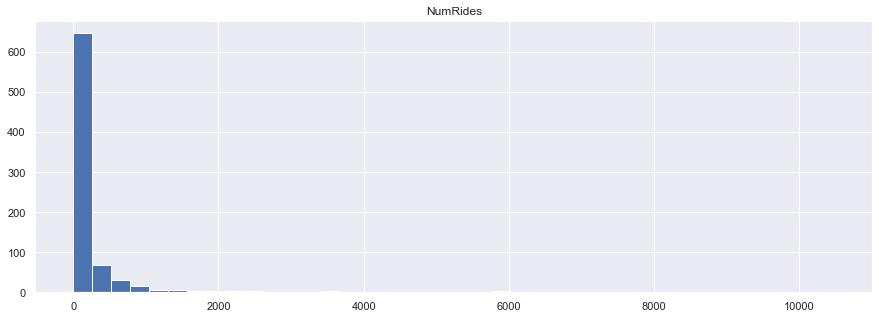

In [467]:
#look at ride counts
allfields.hist('NumRides',bins=40)

In [468]:
allfields.NumRides.sort_values()

PUCensusTract
17031520200        0
17031170600        0
17031520100        0
17031560100        0
17031170900        0
               ...  
17031081800     5652
17031833000     5789
17031081700     5902
17031320100     6024
17031839100    10481
Name: NumRides, Length: 796, dtype: int64

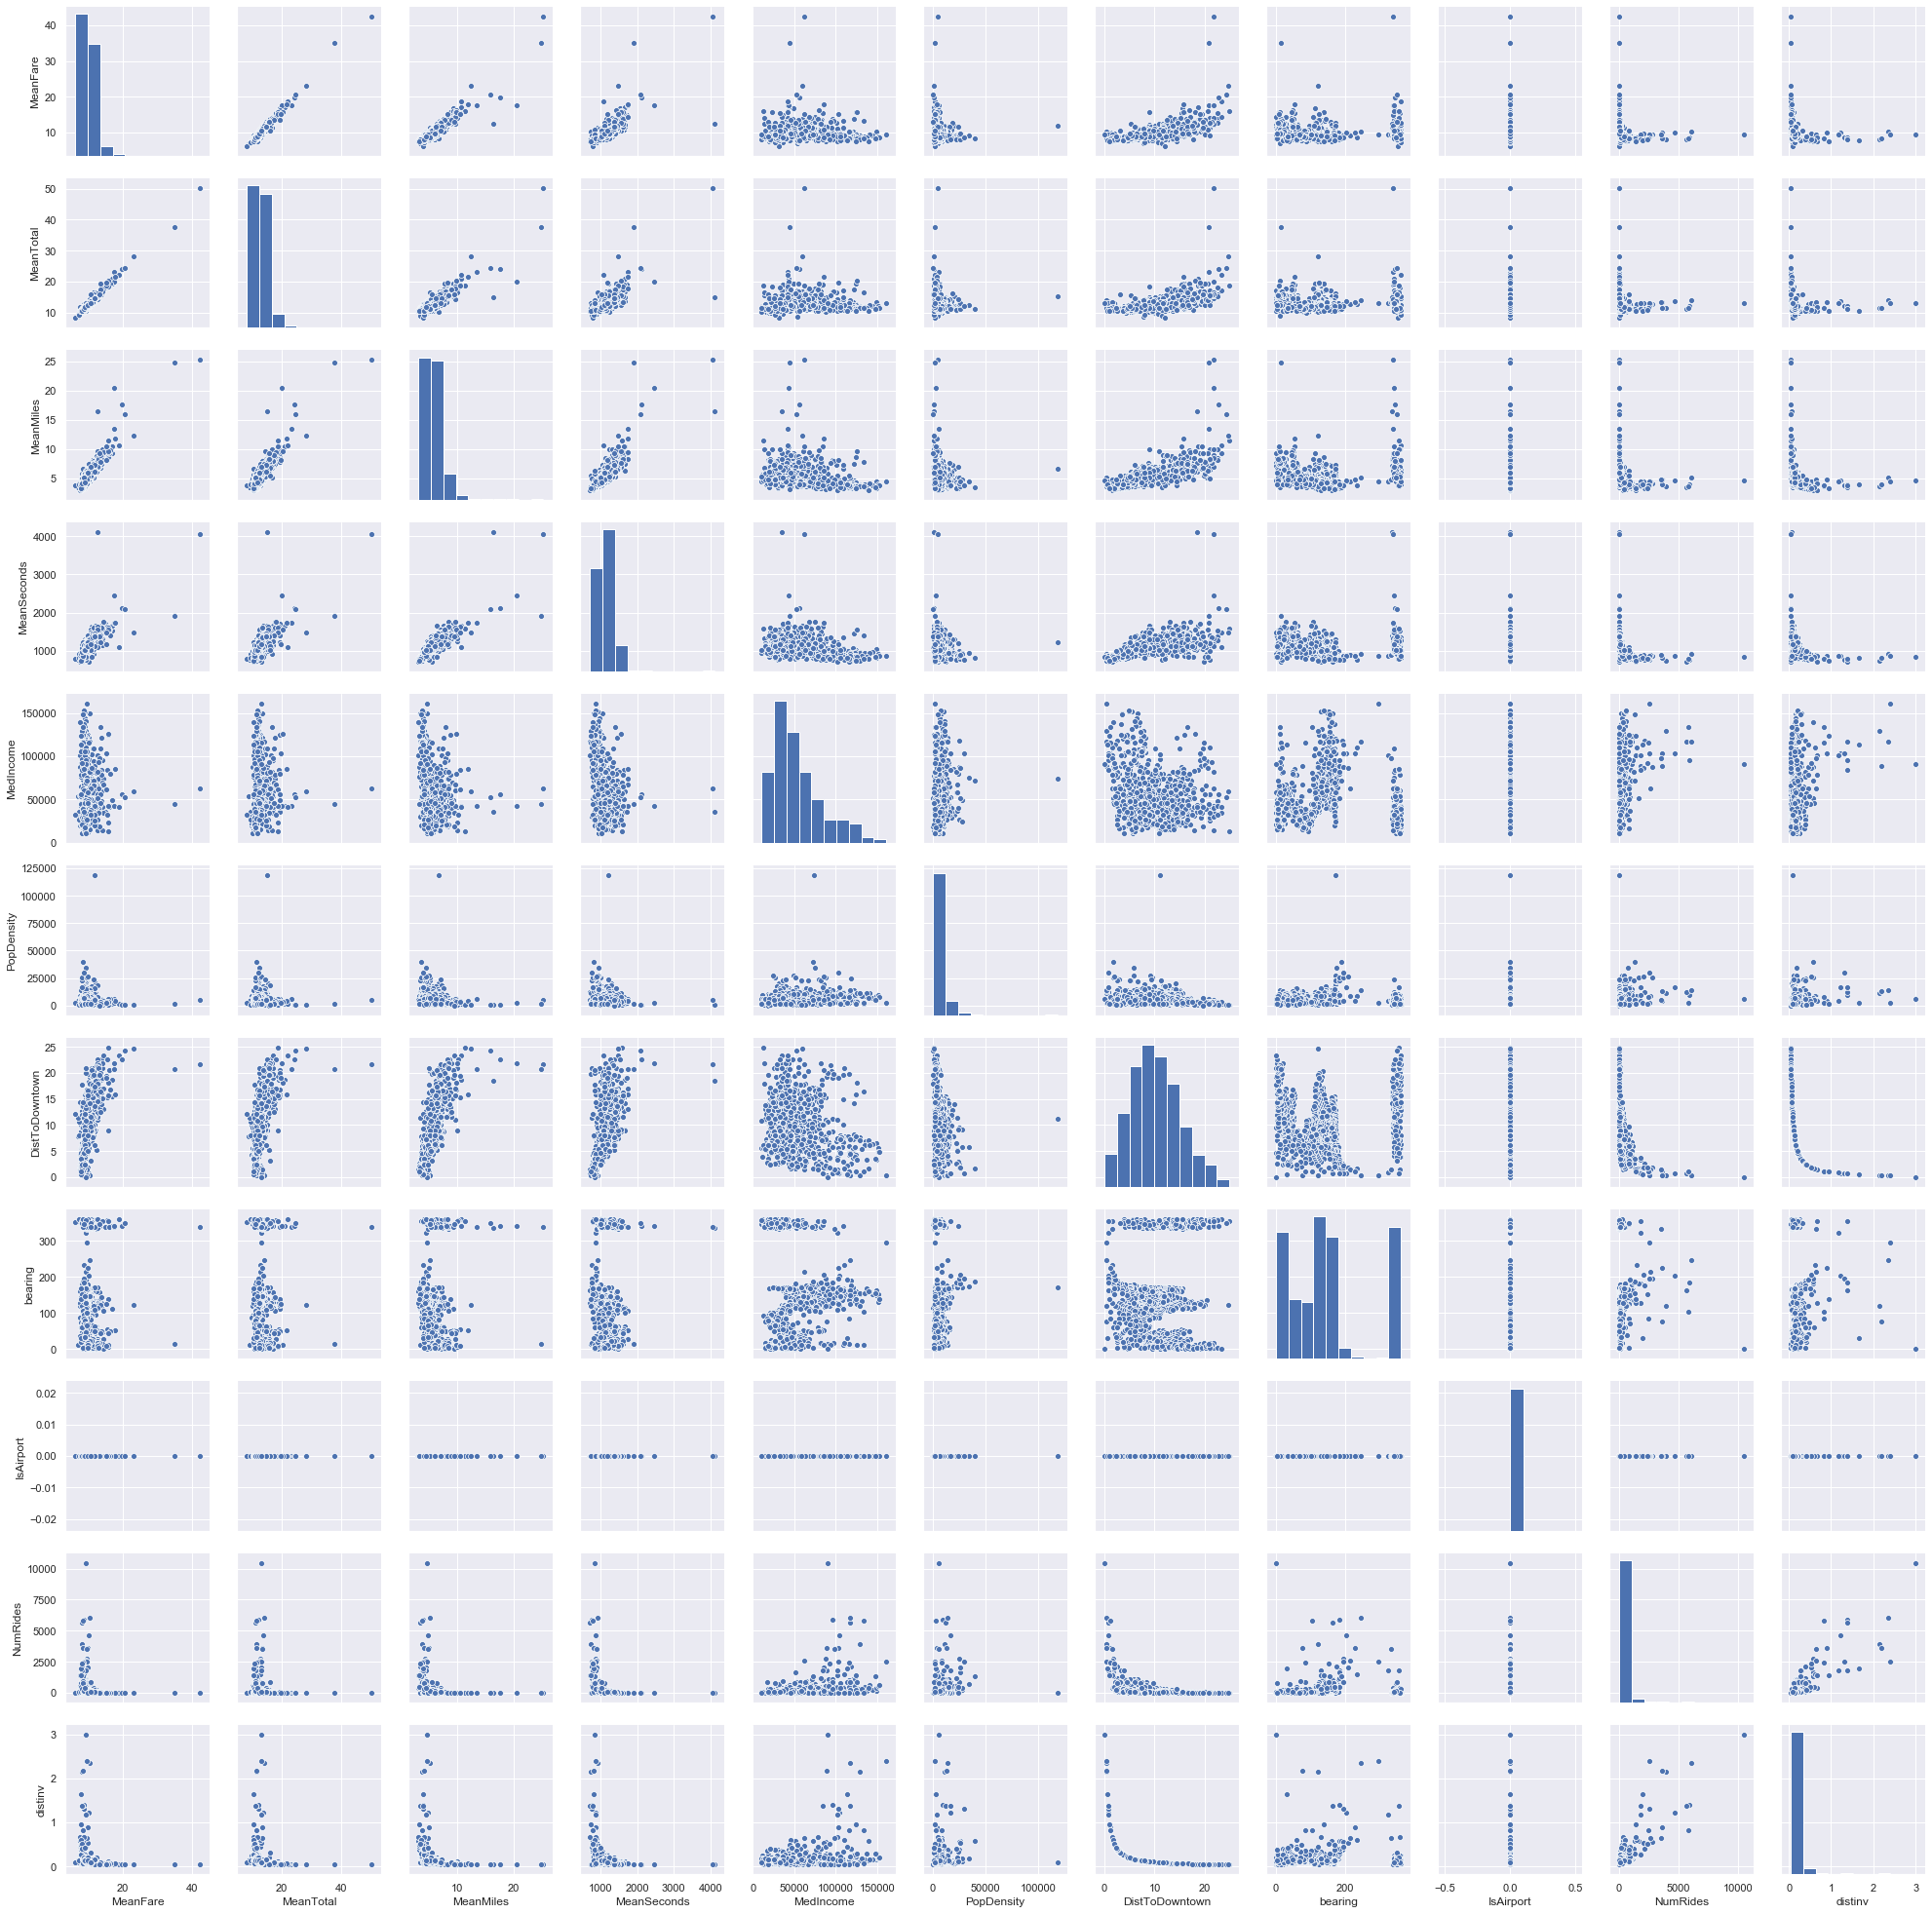

In [469]:
sns.pairplot(allfields)

In [485]:
#Try with Negative Binomial to account for overdispersion
glm_results=smf.glm('NumRides ~ DistToDowntown+PopDensity',data=allfields,family=sm.families.NegativeBinomial()).fit()
#increase alpha to account for more overdispersion
print(glm_results.pearson_chi2/glm_results.df_resid)
glm_results.summary()


1.6452061810019083


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               NumRides   No. Observations:                  796
Model:                            GLM   Df Residuals:                      793
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4486.9
Date:                Wed, 13 Nov 2019   Deviance:                       1192.5
Time:                        12:58:11   Pearson chi2:                 1.30e+03
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.6947      0.103     64.741      0.000       6.492       6.897
DistToDowntown    -0.2331      0.008    -30.662      0.000      -0.248      -0.218
PopDensity      4.463e-05   6.05e-06      7.382      0.000    3.28e-05    5.65e-05
==================================================================================
"""

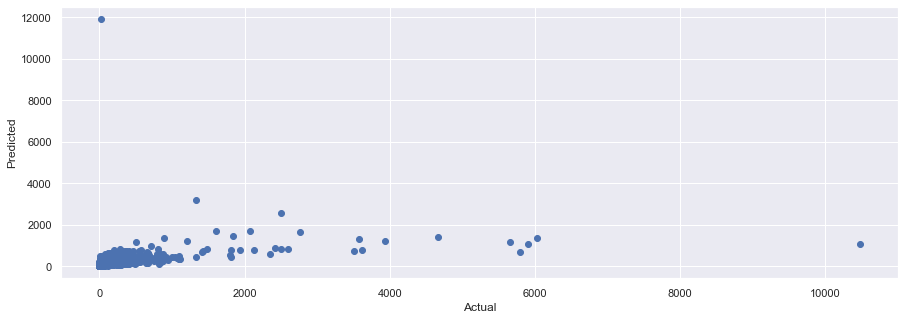

In [486]:
#simple plot of actual v predicted, does not look good
plt.scatter(allfields['NumRides'],glm_results.fittedvalues)
plt.xlabel('Actual')
plt.ylabel('Predicted');
#plt.ylim(0,15000);


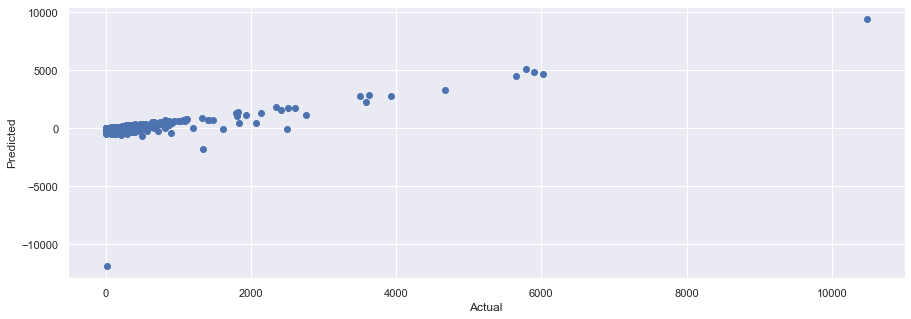

In [487]:
#residuals plot
plt.scatter(allfields['NumRides'],allfields['NumRides']-glm_results.fittedvalues)
plt.xlabel('Actual')
plt.ylabel('Predicted');
